Data Ingestion and Cleaning

In [1]:
import re, duckdb
from pathlib import Path

# Paths (edit if needed)
DUCKDB_PATH = Path(r"C:\Users\NicholasHarris\Storage Rentals of America\Operations - Revenue Management\Promo Analysis\Move In Regression.duckdb")
RAW_DIRS     = [Path(r"C:\Users\NicholasHarris\Storage Rentals of America\Operations - Revenue Management\PricingToolPBI"), Path(r"C:\Raw_Tables")]
#PUBLISH_DIR = Path(r"C:\Users\NicholasHarris\OneDrive - Storage Rentals of America\Python Files\Publish\Parquet")

def safe_ident(name: str) -> str:
    """Turn a filename into a safe SQL identifier: e.g., 'Units.csv' -> 'units'."""
    s = re.sub(r"[^A-Za-z0-9_]", "_", Path(name).stem)
    if s[:1].isdigit(): s = "_" + s
    return s.lower()

def ensure_open(conn, db_path: Path, *, read_only=False):
    """Return an open DuckDB connection to db_path; reopen if missing/closed."""
    try:
        if conn is None: raise RuntimeError("no conn")
        conn.execute("SELECT 1")
        return conn
    except Exception:
        return duckdb.connect(db_path.as_posix(), read_only=read_only)


In [2]:
# Open (or reopen) the DuckDB file and ensure schemas exist
con = ensure_open(globals().get("con"), DUCKDB_PATH)
con.execute("CREATE SCHEMA IF NOT EXISTS raw;")
con.execute("CREATE SCHEMA IF NOT EXISTS gold;")
print("Connected to", DUCKDB_PATH)


Connected to C:\Users\NicholasHarris\Storage Rentals of America\Operations - Revenue Management\Promo Analysis\Move In Regression.duckdb


In [3]:
# IMPORTANT: ensure the connection is open immediately before using it
con = ensure_open(con, DUCKDB_PATH)

# Force text for tricky columns in specific files
TYPE_OVERRIDES = {
    "Units.csv": {"dcLength": "VARCHAR"},   # your failing column
    "Pri_Competitors.csv" : {"Date": "DATE"}                                                                          
    # add more files/columns if needed
}

for raw_dir in RAW_DIRS:                         # iterate the list
    for fp in sorted(raw_dir.glob("*.csv")):     # glob on each Path
        view_name = f"raw.{safe_ident(fp.name)}"
        overrides = TYPE_OVERRIDES.get(fp.name)

        if overrides:
            types_literal = "{" + ", ".join(f"'{k}':'{v}'" for k, v in overrides.items()) + "}"
            sql = f"""
            CREATE OR REPLACE VIEW {view_name} AS
            SELECT *
            FROM read_csv_auto('{fp.as_posix()}', header=TRUE, sample_size=-1, types={types_literal});
            """
        else:
            sql = f"""
            CREATE OR REPLACE VIEW {view_name} AS
            SELECT *
            FROM read_csv_auto('{fp.as_posix()}', header=TRUE, sample_size=-1);
            """
        con.execute(sql)
        print("VIEW:", view_name, "->", fp)


VIEW: raw.chargedesc -> C:\Users\NicholasHarris\Storage Rentals of America\Operations - Revenue Management\PricingToolPBI\ChargeDesc.csv
VIEW: raw.charges -> C:\Users\NicholasHarris\Storage Rentals of America\Operations - Revenue Management\PricingToolPBI\charges.csv
VIEW: raw.comp_filter -> C:\Users\NicholasHarris\Storage Rentals of America\Operations - Revenue Management\PricingToolPBI\comp_filter.csv
VIEW: raw.comp_month -> C:\Users\NicholasHarris\Storage Rentals of America\Operations - Revenue Management\PricingToolPBI\comp_month.csv
VIEW: raw.comp_week -> C:\Users\NicholasHarris\Storage Rentals of America\Operations - Revenue Management\PricingToolPBI\comp_week.csv
VIEW: raw.competitors_locations -> C:\Users\NicholasHarris\Storage Rentals of America\Operations - Revenue Management\PricingToolPBI\competitors_locations.csv
VIEW: raw.ecri_history -> C:\Users\NicholasHarris\Storage Rentals of America\Operations - Revenue Management\PricingToolPBI\ECRI_History.csv
VIEW: raw.ledgers -> 

In [4]:
# Core
import pandas as pd
import numpy as np

# Modeling
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Diagnostics
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Optional ML extensions
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso


In [5]:
MonthlyWebsiteSessions = con.execute("""
WITH LOCATION AS (
SELECT 
    *,
    REGEXP_EXTRACT(URL, '[^/]+$', 0) AS URL_ID_2
FROM raw.location
)
SELECT
DISTINCT
    l."Property #",
    --CAST(ws.date AS Date) Date,
    date_trunc('month', CAST(ws.date AS Date)) Month_Of,
    --l.Store,
    --ws."URL ID",
    --l."URL ID",
    --l.URL,
    --l.URL_ID_2,
    --l.Market,
    --l.district,
    --ws.sessions Daily_Sessions,
    SUM(ws.sessions) OVER (PARTITION BY "Property #", date_trunc('month', CAST(ws.date AS Date))) Monthly_Sessions,
    REGEXP_EXTRACT(ws."URL ID", '[^/]+$', 0) AS URL_ID_2
FROM raw.websitesessions ws
RIGHT JOIN LOCATION l 
ON l."URL_ID_2" = REGEXP_EXTRACT(ws."URL ID", '[^/]+$', 0)
--AND l.Date = CAST(ws.Date AS Date) 
WHERE Source <> 'Direct'""").df()
display(MonthlyWebsiteSessions)

,Property #,Month_Of,Monthly_Sessions,URL_ID_2
0,L001O,2025-08-01,225.0,morehead-1
1,L006A,2024-06-01,18.0,west-liberty-8
2,L028O,2024-10-01,444.0,nicholasville-28
3,L040O,2024-03-01,319.0,simpsonville-40
4,L049O,2023-02-01,200.0,new-castle-49
...,...,...,...,...
17819,L470O,2025-05-01,94.0,clarksville-650-huntco-dr
17820,L483O,2025-07-01,130.0,hodgenville-1270-old-elizabethtown-rd
17821,L529O,2025-03-01,132.0,jackson-5831-hwy-80-w
17822,L547O,2024-08-01,133.0,north-huntingdon-1001-bridge-st


In [6]:
con.execute(""" SELECT * FROM raw.ledgers """).df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,LedgerID,SiteID,unitID,iLeaseNum,dMovedIn,dSchedOut,dMovedOut,iTferToLedID,iTferFromLedID,dcInsurPremium,...,dPaidThru,bExcludeFromRevenueMgmt,iAuctionStatus,dAuctionDate,dAutoBillEnabled,dcPushRateAtMoveIn,Access.AccessID,Access.TenantID,Tenant and Unit ID,UniqueID
0,1194127,43271,338060,2099,2025-11-25,None,NaT,NaN,NaN,14.0,...,2025-11-30,False,0,NaT,NaT,0.0,1195738,1451277,1451277-338060,1451277-338060-1194127
1,1193779,43245,140058,2060,2025-11-24,None,NaT,NaN,NaN,17.0,...,2026-01-31,False,0,NaT,NaT,0.0,1195391,1450921,1450921-140058,1450921-140058-1193779
2,1193780,33219,69554,4154,2025-11-24,None,NaT,NaN,NaN,0.0,...,2026-01-31,False,0,NaT,NaT,0.0,1195392,1450919,1450919-69554,1450919-69554-1193780
3,1193781,51998,240119,977,2025-11-24,None,NaT,NaN,NaN,14.0,...,2025-11-30,False,0,NaT,NaT,0.0,1195393,1450658,1450658-240119,1450658-240119-1193781
4,1193782,53471,283093,737,2025-11-24,None,NaT,NaN,NaN,14.0,...,2025-11-30,False,0,NaT,2025-11-24,0.0,1195394,1450924,1450924-283093,1450924-283093-1193782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
937959,865836,53338,262555,7,1976-11-02,None,NaT,NaN,NaN,0.0,...,2025-12-31,False,0,NaT,NaT,NaN,867677,1096904,1096904-262555,1096904-262555-865836
937960,354148,41393,121415,1,1976-11-01,Microsoft.OleDb.Date,2021-08-28,NaN,NaN,14.0,...,2021-08-28,False,1,2021-08-27 10:00:00,NaT,NaN,355229,442059,442059-121415,442059-121415-354148
937961,917176,53719,307408,129,1974-05-10,Microsoft.OleDb.Date,2025-10-03,NaN,NaN,0.0,...,2025-10-03,False,1,2025-10-03 10:00:00,NaT,NaN,919360,1149702,1149702-307408,1149702-307408-917176
937962,487435,46049,157011,244,1947-05-01,Microsoft.OleDb.Date,2015-01-13,NaN,NaN,0.0,...,2015-01-13,False,0,NaT,NaT,NaN,489262,612077,612077-157011,612077-157011-487435


In [7]:
#Data Import
Moveins = con.execute("""
WITH units AS (
  SELECT
      U.UnitID,
      L."Property #",
      L."Loc #",
      L.State, L.Facility, L.District, L.Market,
      U."Unit Size",
      UT."Unit Type Abbrev",
      CASE WHEN "Unit Type Abbrev" IN ('CC','DU','IN','LK') THEN 'Storage'
           WHEN "Unit Type Abbrev" =  'PK'                  THEN 'Parking'
           WHEN "Unit Type Abbrev" IN ('WL','WH')           THEN 'Wine'
           ELSE 'Non-Storage' END AS Inventory_Category,
      U.iFloor,
      U.Sq_Footage,
      L.Maturity
  FROM raw.UNITS U
  JOIN raw.Location  L  ON U.SiteIDAddressID = L.SiteID
  JOIN raw.unittypes UT ON UT.UnitTypeID     = U.UnitTypeID
),
ledgers_clean AS (
  SELECT
      LC.*,

      -- dMovedIn → DATE
      CAST(
        COALESCE(
          TRY_CAST(LC.dMovedIn AS TIMESTAMP),
          TRY_STRPTIME(CAST(LC.dMovedIn AS VARCHAR),
                       ['%Y-%m-%d','%m/%d/%Y','%m/%d/%y','%m/%d/%Y %H:%M:%S'])
        )
      AS DATE) AS dmi,

      -- dMovedOut → DATE
      CAST(
        COALESCE(
          TRY_CAST(LC.dMovedOut AS TIMESTAMP),
          TRY_STRPTIME(CAST(LC.dMovedOut AS VARCHAR),
                       ['%Y-%m-%d','%m/%d/%Y','%m/%d/%y','%m/%d/%Y %H:%M:%S'])
        )
      AS DATE) AS dmo

  FROM raw.ledgers LC
),
Monthly AS (
  SELECT
      U."Property #",
      DATE_TRUNC('Month', dmi)::DATE AS Month_Of,
      COUNT(*) AS MoveIns
  FROM ledgers_clean LC
  JOIN units U ON U.UnitID = LC.UnitID
  WHERE LC.iTferFromLedID IS NULL
    AND dmi IS NOT NULL
    AND DATEDIFF('day', dmi, COALESCE(dmo, CURRENT_DATE)) > 2
  GROUP BY 1,2
)
SELECT * FROM Monthly
ORDER BY 1,2;
""").df()

display(Moveins)



,Property #,Month_Of,MoveIns
0,L001A,1998-04-01,1
1,L001A,2000-06-01,1
2,L001A,2002-07-01,1
3,L001A,2002-10-01,1
4,L001A,2003-01-01,1
...,...,...,...
80963,L647O,2025-07-01,59
80964,L647O,2025-08-01,49
80965,L647O,2025-09-01,44
80966,L647O,2025-10-01,50


In [8]:
con.execute("""
 SELECT 
      Date,
      CAST(date_trunc('week', Date) AS DATE) AS Week_Of,
      "Loc Address" AS "Property #", -- stable index
      "Occ %"                                      AS OccPct,
      LEAST("Avg Push Rate","Avg Std Rate")        AS Street_Rate,
      "Avg Rent"                                   AS Occupied_Rate,
      "Units Unrentable"                           AS Units_Unrentable,
      "Units Vacant"                               AS Units_Vacant,
      AVG("Units Vacant") OVER (PARTITION BY "Property #", Week_Of) AS Sum_Units_Vacant,
      "Units Total"                                AS Units_Total,
      "Units Reserved"                             AS Units_Reserved,
      ("Units Total" - "Units Unrentable")         AS Units_Rentable, 
      ("Units Total" - "Units Unrentable" - "Units Vacant") AS Units_Occupied,
      Area,
      "Unit Type Abbrev"
  FROM raw.Pri_Occ
  WHERE Date >= DATE '2023-01-01'
""").df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,Date,Week_Of,Property #,OccPct,Street_Rate,Occupied_Rate,Units_Unrentable,Units_Vacant,Sum_Units_Vacant,Units_Total,Units_Reserved,Units_Rentable,Units_Occupied,Area,Unit Type Abbrev
0,2024-04-09,2024-04-08,L001A,0.636364,115.0,186.000,0,4,4.873016,11,0,11,7,200,DU
1,2024-04-08,2024-04-08,L001A,0.636364,115.0,186.000,0,4,4.873016,11,0,11,7,200,DU
2,2024-04-08,2024-04-08,L001A,0.812500,224.0,282.615,0,3,4.873016,16,0,16,13,200,CC
3,2024-04-08,2024-04-08,L001A,0.750000,254.0,280.333,1,0,4.873016,4,0,3,3,300,DU
4,2024-04-08,2024-04-08,L001A,0.750000,122.0,183.889,0,3,4.873016,12,1,12,9,100,CC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7723041,2025-11-22,2025-11-17,L644O,1.000000,135.0,125.000,0,0,2.923077,1,0,1,1,120,DU
7723042,2025-11-22,2025-11-17,L644O,1.000000,295.0,227.000,0,0,2.923077,1,0,1,1,170,DU
7723043,2025-11-23,2025-11-17,L644O,1.000000,239.0,179.000,0,0,2.923077,1,0,1,1,160,CC
7723044,2025-11-23,2025-11-17,L644O,1.000000,295.0,227.000,0,0,2.923077,1,0,1,1,170,CC


In [9]:
MoveInRevenue = con.execute("""
WITH BASE AS(
SELECT
    L."Property #",
    "Unit Size",
    "Unit Type Abbrev",
    U.UnitID,
    U.iFLoor,
    UT."Unit Type Abbrev",
    U.Sq_Footage 
FROM raw.UNITS U
JOIN raw.Location L ON
    U.SiteIDAddressID = L.SiteID
JOIN raw.unittypes UT ON
    UT.UnitTypeID = U. UnitTypeID
), REVENUE AS (
SELECT
    B."Property #",
    C.dchgStrt,
    C.dChgEnd,
    C.RentalRate,
    date_trunc('month', dChgStrt) Charge_Month,
    CASE WHEN C.dchgStrt = MIN(C.dchgStrt) OVER (PARTITION BY LE.LedgerID) AND C.RentalRate > 0  AND MIN(C.dchgStrt) <> C.dchgEnd Then TRUE ELSE FALSE END AS FirstRent
FROM raw.Charges C
JOIN raw.LEDGERS LE
    ON C.LedgerID = LE.LedgerID
JOIN raw.ChargeDesc CD 
    ON CD.ChargeDescID = C.ChargeDescID 
JOIN BASE B on B.UnitID = LE.UnitID
WHERE dChgStrt <= current_date()
    AND dChgStrt >= '2023-01-01'
    AND CD.sChgDesc = 'Rent' 
GROUP BY 
    LE.LedgerID,
    C.dchgStrt,
    C.dchgEnd,
    C.RentalRate,
    "Property #",
)
SELECT 
DISTINCT
    "Property #",
    Charge_Month,
    SUM(CASE WHEN FirstRent = True THEN RentalRate ELSE 0 END) OVER (PARTITION BY "Property #", date_trunc('month', dChgStrt)) MI_Rent_Revenue,
    SUM(RentalRate) OVER (PARTITION BY "Property #", date_trunc('month', dChgStrt)) Rent_Revenue,
FROM REVENUE 
WHERE dChgStrt <> dChgEnd
""").df()
display(MoveInRevenue)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,Property #,Charge_Month,MI_Rent_Revenue,Rent_Revenue
0,L003O,2023-11-01,756.9671,14479.6471
1,L010O,2025-01-01,340.9601,28176.0501
2,L018O,2025-09-01,2350.0060,49905.0560
3,L041A,2025-04-01,230.9836,16420.4836
4,L070O,2024-03-01,6027.8938,151325.9738
...,...,...,...,...
17533,L585O,2025-02-01,618.0129,24283.1245
17534,L610B,2023-06-01,1361.9870,34244.5270
17535,L610O,2024-02-01,973.2319,29300.2018
17536,L611O,2025-02-01,696.0010,18362.2720


In [10]:
Street_Rate = con.execute("""
WITH base AS (
  SELECT
      CAST(date_trunc('month', Date) AS DATE) AS Month_Of,
      Date,
      "Loc Address" AS "Property #",
      LEAST("Avg Push Rate","Avg Std Rate")    AS Street_Rate,   -- $ per unit
      "Avg Rent"                               AS Occupied_Rate, -- optional
      ("Units Total" - "Units Unrentable")     AS Units_Rentable,
      SUM("Units Total") OVER (PARTITION BY Date, "Loc Address") "Units Total",
      COALESCE(Area, 0)                        AS Area
  FROM raw.Pri_Occ
  WHERE Date >= DATE '2023-01-01'
)
SELECT
    "Property #",
    Month_Of,
    ROUND(
      SUM(Street_Rate * Units_Rentable) / NULLIF(SUM(Area * Units_Rentable), 0)
    , 2) AS Street_Rate_Sqft,
    --AVG(Units_Rentable) AS Units_Rentable_Month,
    AVG("Units Total") "Units Total",
    AVG(Area) Area
FROM base
GROUP BY 1,2
ORDER BY 1,2;
""").df()

display(Street_Rate)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,Property #,Month_Of,Street_Rate_Sqft,Units Total,Area
0,L001A,2023-01-01,0.95,100.000000,143.750000
1,L001A,2023-02-01,0.93,100.000000,143.750000
2,L001A,2023-03-01,0.92,100.000000,143.750000
3,L001A,2023-04-01,0.86,100.000000,143.750000
4,L001A,2023-05-01,0.79,100.000000,143.750000
...,...,...,...,...,...
18756,L643O,2025-11-01,1.47,621.000000,156.351351
18757,L644O,2025-11-01,1.05,572.522727,150.954545
18758,L645O,2025-11-01,2.24,535.516129,141.580645
18759,L646O,2025-11-01,1.51,649.000000,146.914286


In [11]:
Marketing_Spend = con.execute(""" SELECT
  "Property_#" AS "Property #",
  --l."Loc #",
  "Budget - Google Ads",
  "Google Spend",
CAST(strptime(CAST("Date" AS VARCHAR), '%Y-%d-%m') AS DATE) AS Month_Of,
FROM raw.marketingspend ms
""").df()

display(Marketing_Spend)

,Property #,Budget - Google Ads,Google Spend,Month_Of
0,L001A,627.8,0.00,2018-01-01
1,L059O,1100.0,194.44,2022-12-01
2,L001O,308.8,0.00,2018-01-01
3,L055O,752.0,154.81,2022-12-01
4,L002A,240.0,0.00,2018-01-01
...,...,...,...,...
29581,L620O,1636.0,0.00,2025-11-01
29582,L620O,1686.0,0.00,2025-12-01
29583,L629O,1506.0,0.00,2025-10-01
29584,L629O,1506.0,0.00,2025-11-01


In [12]:
con.execute(""" SELECT * FROM raw.units""").df()

,UnitID,SiteID,UnitTypeID,sUnitName,iFloor,dcWidth,dcLength,dcPushRate,dcStdRate,bRentable,...,dUnitNote,bDamaged,bExcludeFromSqftReports,bExcludeFromWebsite,Sq_Footage,SiteIDAddressID,Unit Size,Size of Unit,location.Loc #,location.Property #
0,323932,54436,6091,H0375,1,5.0,5.0,34.5,30,True,...,None,False,False,False,25.0,54436H,5x5,Small,None,None
1,265484,53349,5128,A071,1,10.0,15.0,155,155,True,...,None,False,False,False,150.0,53349,10x15,Medium,None,None
2,265483,53349,5128,A070,1,10.0,15.0,155,155,True,...,None,False,False,False,150.0,53349,10x15,Medium,None,None
3,265482,53349,5128,A069,1,10.0,15.0,155,155,True,...,None,False,False,False,150.0,53349,10x15,Medium,None,None
4,265481,53349,5128,A068,1,10.0,15.0,155,155,True,...,None,False,False,False,150.0,53349,10x15,Medium,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285064,347985,57392,7126,2154,2,10.0,10.0,135.15,159,True,...,None,False,False,False,100.0,57392,10x10,Medium,L647,L647O
285065,347984,57392,7126,2153,2,7.5,10.0,101.15,119,True,...,None,False,False,False,75.0,57392,7.5x10,Small,L647,L647O
285066,347983,57392,7126,2152,2,10.0,10.0,135.15,159,True,...,None,False,False,False,100.0,57392,10x10,Medium,L647,L647O
285067,347981,57392,7126,2150,2,10.0,10.0,135.15,159,True,...,None,False,False,False,100.0,57392,10x10,Medium,L647,L647O


In [13]:
LocationData = con.execute("""
SELECT DISTINCT
    l."Property #" || '-' || Facility AS Property,
    COUNT(UnitID) OVER (PARTITION BY l."Property #") AS Unit_Count,
    ROUND(
        SUM(u.Sq_Footage) OVER(PARTITION BY l."Property #") /
        COUNT(UnitID) OVER (PARTITION BY l."Property #"),
        0
    ) AS Area,
    ROUND(
        SUM(
            COALESCE(
                LEAST(
                    CAST(dcPushRate AS DOUBLE),
                    CAST(dcStdRate AS DOUBLE)
                ),
                0.0
            )
        ) OVER (PARTITION BY l."Property #")
        / NULLIF(SUM(u.Sq_Footage) OVER (PARTITION BY l."Property #"), 0),
        4
    ) AS rate_psf
FROM raw.location l
JOIN raw.units u ON l.SiteID = u.SiteIDAddressID
JOIN raw.unittypes ut ON CAST(ut.UnitTypeID AS VARCHAR) = CAST(u.UnitTypeID AS VARCHAR)
WHERE ut."Unit Type Abbrev" IN ('DU','CC','IN','LK')
""").df()

display(LocationData)
LocationData.to_csv('LocationData.csv', index=False)

,Property,Unit_Count,Area,rate_psf
0,L185A-Chapin 320 Amicks Ferry (A),185,148.0,0.7369
1,L412O-Gulfport 12497 Three Rivers Rd.,214,144.0,0.4216
2,L456O-Griffith 500 East Ridge Rd.,329,83.0,0.9456
3,L460O-Cortland 190 W. Stephenie Dr.,359,168.0,0.6210
4,L458O-DeKalb 202 Harvestore Dr.,621,155.0,0.5590
...,...,...,...,...
591,L200O-Frankfort Prairie St.,194,125.0,0.7112
592,L320O-Bozeman 34 Quinns Rd,352,153.0,0.5837
593,L094O-Kentwood,522,111.0,0.6608
594,L382O-Slidell 775 Brownswitch Rd.,524,151.0,0.4893


In [14]:
import pandas as pd
# ===== 1) Align to MONTH keys (1st of month @ 00:00) =====
# Adjust the column names on the right if yours differ.
MonthlyWebsiteSessions["Month_Of"]  = pd.to_datetime(MonthlyWebsiteSessions["Month_Of"]).dt.to_period("M").dt.start_time
Moveins["Month_Of"]                 = pd.to_datetime(Moveins["Month_Of"]).dt.to_period("M").dt.start_time
Street_Rate["Month_Of"]             = pd.to_datetime(Street_Rate["Month_Of"]).dt.to_period("M").dt.start_time
Marketing_Spend["Month_Of"]         = pd.to_datetime(Marketing_Spend["Month_Of"]).dt.to_period("M").dt.start_time
MoveInRevenue["Charge_Month"]       = pd.to_datetime(MoveInRevenue["Charge_Month"]).dt.to_period("M").dt.start_time
# If Street_Rate uses 'month_start' instead:
# Street_Rate["month_start"] = pd.to_datetime(Street_Rate["month_start"]).dt.to_period("M").dt.start_time

# ===== 2) Unify key names =====
sessions = MonthlyWebsiteSessions.rename(columns={"Month_Of": "Start_of_Month"})
rate     = Street_Rate.rename(columns={"Month_Of": "Start_of_Month"})      # or {"month_start": "Start_of_Month"}
moves    = Moveins.rename(columns={"Month_Of": "Start_of_Month"})
spend    = Marketing_Spend.rename(columns={"Month_Of": "Start_of_Month"})
revenue  = MoveInRevenue.rename(columns={"Charge_Month": "Start_of_Month"})
# ===== 3) Trim to needed columns (change as needed) =====
moveins_keep = moves[["Property #", "Start_of_Month", "MoveIns"]]
price_keep   = rate[["Property #", "Start_of_Month", "Street_Rate_Sqft", "Units Total", "Area"]]   # or your price column
revenue_keep = revenue[["Property #", "Start_of_Month", "MI_Rent_Revenue"]]
# ===== 4) Merge (keep all months from sessions; use 'outer' for full union) =====
keys = ["Property #", "Start_of_Month"]
merged = (
    sessions
      .merge(moveins_keep, on=keys, how="left")
      .merge(price_keep,   on=keys, how="left")
      .merge(spend, on=keys, how="left")
      .merge(revenue_keep, on=keys, how="left")
)

# ===== 5) Tidy & useful date splits =====
merged["MoveIns"] = merged["MoveIns"].astype("Int64")
merged["Year"]    = merged["Start_of_Month"].dt.year
merged["Month"]   = merged["Start_of_Month"].dt.month
merged["YYYYMM"]  = merged["Start_of_Month"].dt.strftime("%Y-%m")


display(merged)
# display(moveins_keep)
# display(price_keep)
# display(revenue_keep)
# display(spend)
# display(sessions)

,Property #,Start_of_Month,Monthly_Sessions,URL_ID_2,MoveIns,Street_Rate_Sqft,Units Total,Area,Budget - Google Ads,Google Spend,MI_Rent_Revenue,Year,Month,YYYYMM
0,L001O,2025-08-01,225.0,morehead-1,31,0.58,345.000000,143.750000,1010.0,1637.9253,2813.0088,2025,8,2025-08
1,L006A,2024-06-01,18.0,west-liberty-8,2,0.94,35.000000,137.500000,88.0,0.0000,312.0000,2024,6,2024-06
2,L028O,2024-10-01,444.0,nicholasville-28,45,0.71,845.000000,160.645161,2000.0,1680.4100,4499.9342,2024,10,2024-10
3,L040O,2024-03-01,319.0,simpsonville-40,18,0.95,576.357143,91.947368,2432.0,2111.6800,1703.9547,2024,3,2024-03
4,L049O,2023-02-01,200.0,new-castle-49,11,1.55,506.000000,127.272727,720.0,759.5700,1716.9973,2023,2,2023-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17819,L470O,2025-05-01,94.0,clarksville-650-huntco-dr,10,0.70,149.000000,128.571429,285.0,394.2979,867.0385,2025,5,2025-05
17820,L483O,2025-07-01,130.0,hodgenville-1270-old-elizabethtown-rd,5,0.83,136.000000,107.142857,375.0,1170.6840,229.9761,2025,7,2025-07
17821,L529O,2025-03-01,132.0,jackson-5831-hwy-80-w,11,0.55,257.000000,121.875000,693.0,930.5877,892.0249,2025,3,2025-03
17822,L547O,2024-08-01,133.0,north-huntingdon-1001-bridge-st,4,0.89,238.478261,219.230769,1425.0,497.8800,791.0197,2024,8,2024-08


In [15]:
merged_1 = merged.rename(columns={
    "Property #": "Property",
    "Start_of_Month": "Month_Start",
    "Monthly_Sessions": "Sessions",
    "Street_Rate_Sqft": "rate_psf",
    "Budget - Google Ads": "Budget",
    "Google Spend": "Spend",
    "MI_Rent_Revenue": "Revenue",
    "Units Total" : "TotalUnits",
    "Area" : "Average Area"
}).drop_duplicates()
# 1) Drop rows with NaN in Spend or rate_psf
merged_1 = merged_1.dropna(subset=['Spend', 'rate_psf'])

merged_1 = merged_1[merged_1['rate_psf'] < 4].copy()
merged_1 = merged_1[merged_1['Spend'] < 10000].copy()
# 2) Replace NaN in MoveIns with 0
merged_1['MoveIns'] = merged_1['MoveIns'].fillna(0)
display(merged_1)

,Property,Month_Start,Sessions,URL_ID_2,MoveIns,rate_psf,TotalUnits,Average Area,Budget,Spend,Revenue,Year,Month,YYYYMM
0,L001O,2025-08-01,225.0,morehead-1,31,0.58,345.000000,143.750000,1010.0,1637.9253,2813.0088,2025,8,2025-08
1,L006A,2024-06-01,18.0,west-liberty-8,2,0.94,35.000000,137.500000,88.0,0.0000,312.0000,2024,6,2024-06
2,L028O,2024-10-01,444.0,nicholasville-28,45,0.71,845.000000,160.645161,2000.0,1680.4100,4499.9342,2024,10,2024-10
3,L040O,2024-03-01,319.0,simpsonville-40,18,0.95,576.357143,91.947368,2432.0,2111.6800,1703.9547,2024,3,2024-03
4,L049O,2023-02-01,200.0,new-castle-49,11,1.55,506.000000,127.272727,720.0,759.5700,1716.9973,2023,2,2023-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17819,L470O,2025-05-01,94.0,clarksville-650-huntco-dr,10,0.70,149.000000,128.571429,285.0,394.2979,867.0385,2025,5,2025-05
17820,L483O,2025-07-01,130.0,hodgenville-1270-old-elizabethtown-rd,5,0.83,136.000000,107.142857,375.0,1170.6840,229.9761,2025,7,2025-07
17821,L529O,2025-03-01,132.0,jackson-5831-hwy-80-w,11,0.55,257.000000,121.875000,693.0,930.5877,892.0249,2025,3,2025-03
17822,L547O,2024-08-01,133.0,north-huntingdon-1001-bridge-st,4,0.89,238.478261,219.230769,1425.0,497.8800,791.0197,2024,8,2024-08


In [16]:
# import numpy as np
# import pandas as pd
# import pickle
# from sklearn.model_selection import train_test_split, GridSearchCV, GroupKFold
# from sklearn.linear_model import LinearRegression, PoissonRegressor, LogisticRegression
# from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, PolynomialFeatures
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.metrics import mean_absolute_error, mean_squared_error
# import statsmodels.api as sm
# import matplotlib.pyplot as plt
# import seaborn as sns


# # ===== DEFINE NAMED FUNCTIONS FOR PICKLING =====
# def sqrt_transform(x):
#     """Square root transformation"""
#     return np.sqrt(np.clip(x, 0, None))

# def month_cyclical_transform(X):
#     """Cyclical transformation for month"""
#     m = np.asarray(X).astype(float)
#     return np.column_stack([
#         np.sin(2*np.pi*m/12), 
#         np.cos(2*np.pi*m/12)
#     ])

# def month_feature_names(transformer, input_features):
#     """Generate feature names for month transformation"""
#     base = input_features[0] if input_features else 'Month'
#     return np.array([f'{base}_sin', f'{base}_cos'], dtype=object)
# # ================================================


# # Apply all filters in one vectorized operation
# filtered = merged_1.copy()
 
# # 3️⃣ Define features and target
# features = [
#     'rate_psf',
#     'Spend',
#     'Month'
# ]
 
# target = 'MoveIns'
# X = filtered[features]
# y = filtered[target]

# # Split by property
# unique_properties = filtered['Property'].unique()
# train_props, test_props = train_test_split(
#     unique_properties,
#     test_size=0.2,
#     random_state=42
# )
# train_mask = filtered['Property'].isin(train_props)
# test_mask = filtered['Property'].isin(test_props)
 
# X_train = X[train_mask]
# X_test = X[test_mask]
# y_train = y[train_mask]
# y_test = y[test_mask]

# # --- Build offset = log(TotalUnits), clipped to avoid log(0)
# eps = 1.0  # at least 1 unit
# tu_train = np.asarray(filtered.loc[X_train.index, "TotalUnits"], dtype=float)
# tu_test  = np.asarray(filtered.loc[X_test.index,  "TotalUnits"], dtype=float)

# offset_train = np.log(np.clip(tu_train, eps, None))
# offset_test  = np.log(np.clip(tu_test,  eps, None))

# # Identify numeric columns to scale
# cols_to_scale = [col for col in features]

# # Create transformers using named functions
# month_tf = FunctionTransformer(
#     month_cyclical_transform,
#     validate=False,
#     feature_names_out=month_feature_names
# )

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('sqrt_spend', Pipeline([
#             ('sqrt', FunctionTransformer(
#                 sqrt_transform,
#                 validate=False,
#                 feature_names_out='one-to-one'
#             )),
#             ('scale', StandardScaler())
#         ]), ['Spend']),
#         ('rate_scaler', StandardScaler(), ['rate_psf']),
#         ('month_cyc', month_tf, ['Month'])
#     ],
#     remainder='drop'
# )
 
# # 6️⃣ Transform with your existing preprocessor, then fit NB2 (statsmodels)

# # Fit preprocessor on train, transform both
# X_train_mat = preprocessor.fit_transform(X_train)
# X_test_mat  = preprocessor.transform(X_test)

# # Add intercept (constant) for statsmodels
# X_train_sm = sm.add_constant(X_train_mat, has_constant="add")
# X_test_sm  = sm.add_constant(X_test_mat,  has_constant="add")

# # Convert y to 1D float array (statsmodels-friendly)
# y_train_arr = np.asarray(y_train, dtype=float)
# y_test_arr  = np.asarray(y_test, dtype=float)

# # --- Fit GLM Negative Binomial with offset = log(TotalUnits)
# nb_glm = sm.GLM(
#     y_train_arr,
#     X_train_sm,
#     family=sm.families.NegativeBinomial(),
#     offset=offset_train
# )
# nb_res = nb_glm.fit(maxiter=200)

# print("Model training complete!")
# print("\nModel Summary:")
# print(nb_res.summary())


# # Save all necessary components for prediction
# model_artifacts = {
#     'preprocessor': preprocessor,
#     'nb_model': nb_res,
#     'feature_names': features,
#     'eps': eps,  # for offset calculation
#     # Save the functions as well for reference
#     'sqrt_transform': sqrt_transform,
#     'month_cyclical_transform': month_cyclical_transform,
#     'month_feature_names': month_feature_names
# }

# # Save the model artifacts
# with open('moveins_model.pkl', 'wb') as f:
#     pickle.dump(model_artifacts, f)

# print("Model saved successfully as 'moveins_model.pkl'")

# # Optional: Save model summary for reference
# with open('model_summary.txt', 'w') as f:
#     f.write(str(nb_res.summary()))
    
# print("Model summary saved as 'model_summary.txt'")



MAE on test set:  6.4037
RMSE on test set: 8.6374
R² on test set:   0.4992
X_train_sm shape (n, p): (13559, 5)
len(terms): 5
len(beta): 5
len(params): 5 

Coefficients (log scale) and IRR:


C:\Users\NicholasHarris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


,term,coef,IRR
0,Intercept,-3.364939,0.034564
1,sqrt_spend__Spend,0.069683,1.072168
2,rate_scaler__rate_psf,-0.046987,0.954099
3,month_cyc__Month_sin,0.051000,1.052323
4,month_cyc__Month_cos,-0.178085,0.836871


Over-dispersion alpha: nan
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                13559
Model:                            GLM   Df Residuals:                    13554
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -45830.
Date:                Tue, 25 Nov 2025   Deviance:                       15207.
Time:                        15:02:30   Pearson chi2:                 6.70e+03
No. Iterations:                     6   Pseudo R-squ. (CS):            0.02098
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.3649    

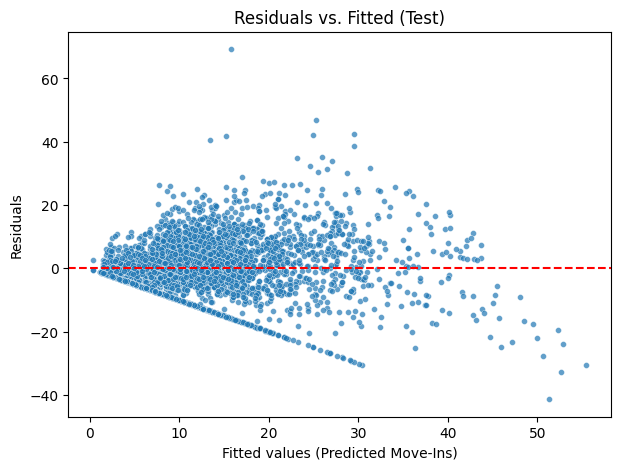

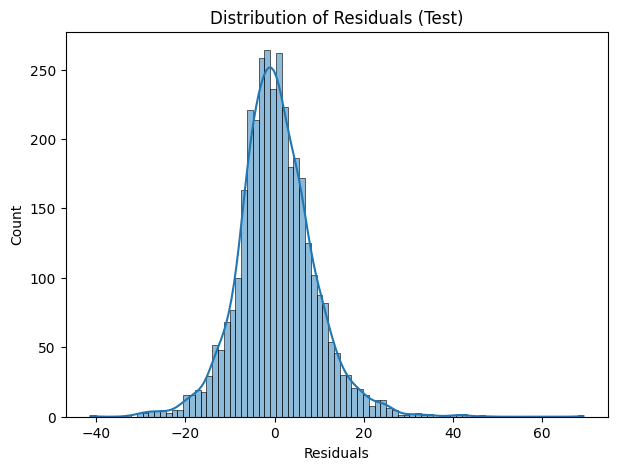

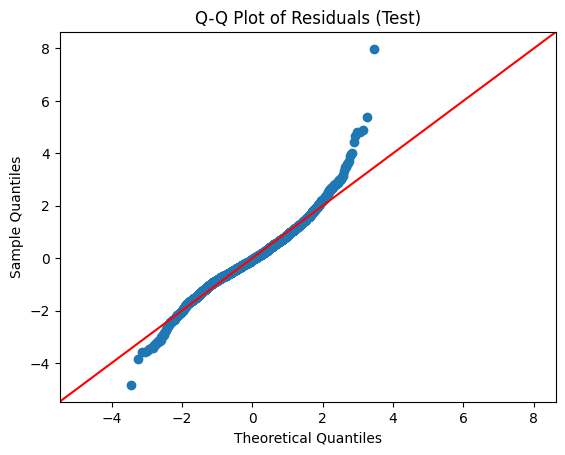

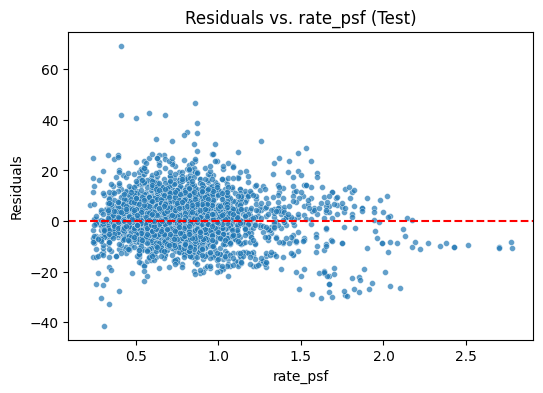

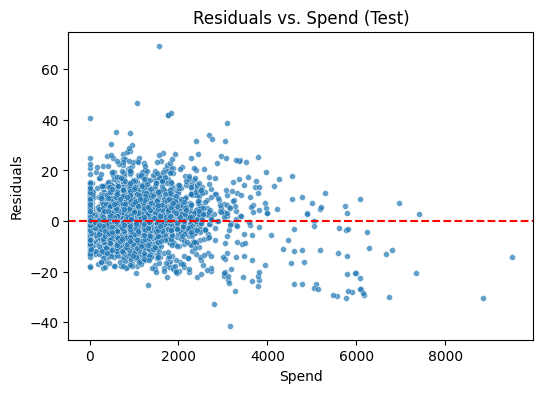

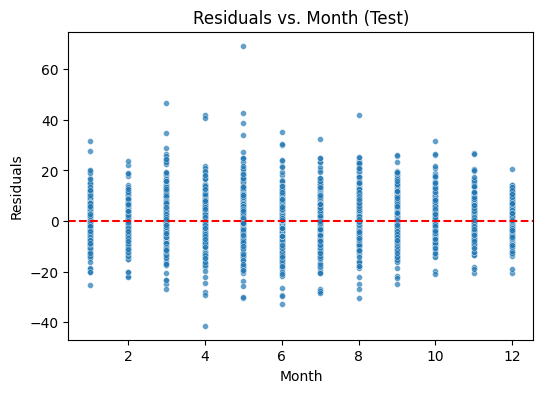

Model saved successfully as 'moveins_model.pkl'
Model summary saved as 'model_summary.txt'


In [18]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, GroupKFold
from sklearn.linear_model import LinearRegression, PoissonRegressor, LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
 

# Apply all filters in one vectorized operation
filtered = merged_1.copy()
 
# 3️⃣ Define features and target
features = [
    'rate_psf',
    'Spend',
    'Month'
]
 
target = 'MoveIns'
X = filtered[features]
y = filtered[target]
#y = np.log1p(filtered[target])  
#y = np.sqrt(np.clip(filtered[target], 0, None))

# 20% test, 80% train
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,
#     test_size=0.8,       # 80% of rows go to test set
#     random_state=42,     # ensures reproducibility
#     shuffle=True         # shuffles before splitting (default=True)
# )

unique_properties = filtered['Property'].unique()
train_props, test_props = train_test_split(
    unique_properties,
    test_size=0.2,
    random_state=42
)
train_mask = filtered['Property'].isin(train_props)
test_mask = filtered['Property'].isin(test_props)
 
X_train = X[train_mask]
X_test = X[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

# --- Build offset = log(TotalUnits), clipped to avoid log(0)
eps = 1.0  # at least 1 unit
tu_train = np.asarray(filtered.loc[X_train.index, "TotalUnits"], dtype=float)
tu_test  = np.asarray(filtered.loc[X_test.index,  "TotalUnits"], dtype=float)

offset_train = np.log(np.clip(tu_train, eps, None))
offset_test  = np.log(np.clip(tu_test,  eps, None))

# Identify numeric columns to scale (excluding perc_cc which gets polynomial treatment)
cols_to_scale = [col for col in features ] # if col != 'perc_cc'
 
# 5️⃣ Preprocess: scale selected columns, apply polynomial transformation to perc_cc
 
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), cols_to_scale)
#         #('poly', PolynomialFeatures(degree=2, include_bias=False), ['perc_cc'])
#     ]
# )
def month_cyclical(X):
    m = np.asarray(X).astype(float)
    return np.column_stack([np.sin(2*np.pi*m/12), np.cos(2*np.pi*m/12)])

# --- Fix this helper: must accept (transformer, input_features) ---
def month_names(transformer, input_features):
    base = input_features[0] if input_features else 'Month'
    return np.array([f'{base}_sin', f'{base}_cos'], dtype=object)

def sqrt_transform(x):
    """Square root transformation"""
    return np.sqrt(np.clip(x, 0, None))

month_tf = FunctionTransformer(
    month_cyclical,  # <-- Use the named function here
    validate=False,
    feature_names_out=month_names
)

preprocessor = ColumnTransformer(
    transformers=[
        ('sqrt_spend', Pipeline([
            ('sqrt', FunctionTransformer(
                sqrt_transform,
                validate=False,
                feature_names_out='one-to-one'
            )),
            ('scale', StandardScaler())
        ]), ['Spend']),
        ('rate_scaler', StandardScaler(), ['rate_psf']),
        ('month_cyc', month_tf, ['Month'])
    ],
    remainder='drop'
)
 
# 6️⃣ Transform with your existing preprocessor, then fit NB2 (statsmodels)

# Fit preprocessor on train, transform both
X_train_mat = preprocessor.fit_transform(X_train)
X_test_mat  = preprocessor.transform(X_test)

# Add intercept (constant) for statsmodels
X_train_sm = sm.add_constant(X_train_mat, has_constant="add")
X_test_sm  = sm.add_constant(X_test_mat,  has_constant="add")

# Convert y to 1D float array (statsmodels-friendly)
y_train_arr = np.asarray(y_train, dtype=float)
y_test_arr  = np.asarray(y_test, dtype=float)

# --- Fit GLM Negative Binomial with offset = log(TotalUnits)
nb_glm = sm.GLM(
    y_train_arr,
    X_train_sm,
    family=sm.families.NegativeBinomial(),
    offset=offset_train
)
nb_res = nb_glm.fit(maxiter=200)

# --- Predict with the SAME offset for test rows
y_pred = nb_res.predict(X_test_sm, offset=offset_test)

mae = mean_absolute_error(y_test_arr, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_arr, y_pred))
# R² on counts is often not very informative, but we can report it
from sklearn.metrics import r2_score
r2 = r2_score(y_test_arr, y_pred)

print(f"\nMAE on test set:  {mae:.4f}")
print(f"RMSE on test set: {rmse:.4f}")
print(f"R² on test set:   {r2:.4f}")

# 10️⃣ Coefficients / IRR table (robust to alpha and naming)

# Try to get names from the preprocessor
try:
    feature_names = list(preprocessor.get_feature_names_out())
except Exception:
    # Fallback to generic names using the transformed matrix shape
    n_feat = X_train_sm.shape[1] - 1  # minus intercept
    feature_names = [f"X{i}" for i in range(n_feat)]

# Terms for the beta coefficients (intercept + features)
terms = ["Intercept"] + feature_names

# Params from statsmodels NB:
#  - first len(terms) entries are beta (intercept + features)
#  - last entry (if present) is alpha (over-dispersion)
params = nb_res.params
expect_with_alpha = X_train_sm.shape[1] + 1  # p (incl intercept) + 1 alpha
has_alpha = (len(params) == expect_with_alpha)

if has_alpha:
    beta = params[:-1]
    alpha = float(params[-1])
else:
    beta = params
    alpha = np.nan

# Sanity checks (should match)
print("X_train_sm shape (n, p):", X_train_sm.shape)
print("len(terms):", len(terms))
print("len(beta):", len(beta))
print("len(params):", len(params), " (includes alpha)" if has_alpha else "")

# Build table
coef_df = pd.DataFrame({"term": terms, "coef": beta})
coef_df["IRR"] = np.exp(coef_df["coef"])  # Incident Rate Ratios
print("\nCoefficients (log scale) and IRR:")
display(coef_df)

print("Over-dispersion alpha:", alpha)
print(nb_res.summary())


# 🔟 Residual diagnostics (on test)
residuals = y_test_arr - y_pred

# --- Residuals vs. Fitted ---
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_pred, y=residuals, s=18, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted values (Predicted Move-Ins)")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted (Test)")
plt.show()

# --- Histogram of Residuals ---
plt.figure(figsize=(7, 5))
sns.histplot(residuals, kde=True)
plt.xlabel("Residuals")
plt.title("Distribution of Residuals (Test)")
plt.show()

# --- Optional: Q-Q plot of residuals (NB residuals needn't be normal; use with caution)
sm.qqplot(residuals, line='45', fit=True)
plt.title("Q-Q Plot of Residuals (Test)")
plt.show()

# --- Optional: Residuals vs. Each original feature ---
for col in features:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=X_test[col], y=residuals, s=18, alpha=0.7)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel(col)
    plt.ylabel("Residuals")
    plt.title(f"Residuals vs. {col} (Test)")
    plt.show()

    
model_artifacts = {
    'preprocessor': preprocessor,
    'nb_model': nb_res,
    'feature_names': features,
    'eps': eps,  # for offset calculation
    # Save the functions as well for reference
    'sqrt_transform': sqrt_transform,
    'month_cyclical_transform': month_cyclical,
    'month_feature_names': month_names
}

# Save the model artifacts
with open('moveins_model.pkl', 'wb') as f:
    pickle.dump(model_artifacts, f)

print("Model saved successfully as 'moveins_model.pkl'")

# Optional: Save model summary for reference
with open('model_summary.txt', 'w') as f:
    f.write(str(nb_res.summary()))
    
print("Model summary saved as 'model_summary.txt'")


In [ ]:
# import pickle

# # Save both the model results and preprocessor
# model_artifacts = {
#     'nb_results': nb_res,
#     'preprocessor': preprocessor,
#     'feature_names': feature_names,
#     'features': features  # The original feature column names
# }

# # Save to pickle file
# with open('test.pkl', 'wb') as f:
#     pickle.dump(model_artifacts, f)

# print("Model saved successfully!")

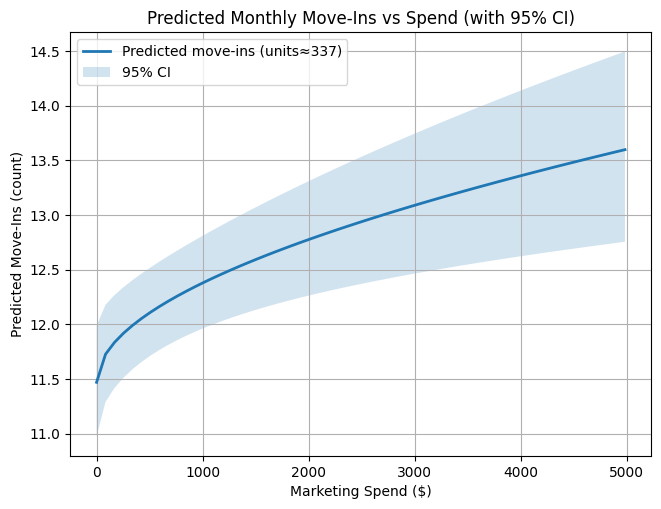

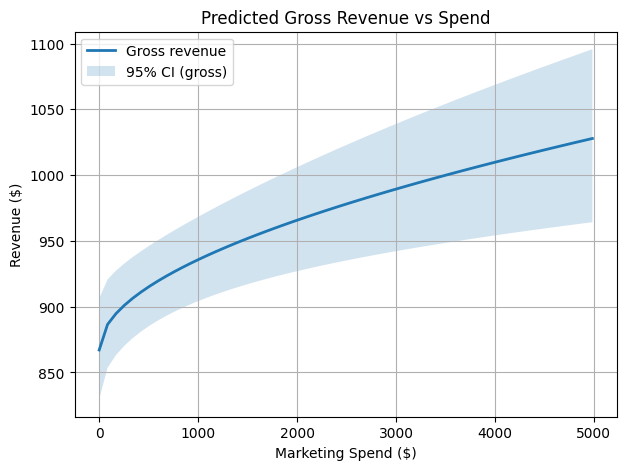

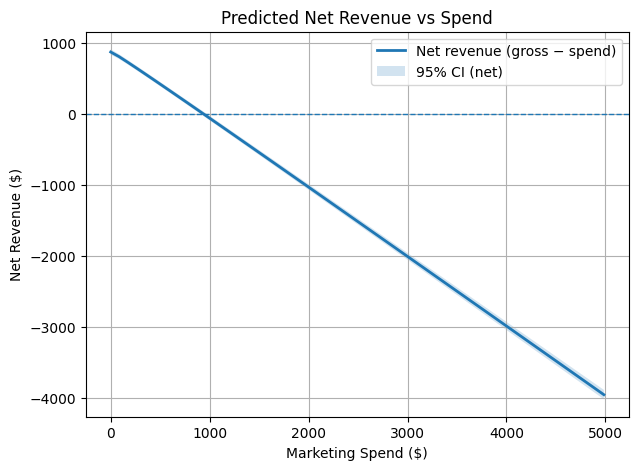

In [ ]:
# import datetime
# current_month = datetime.datetime.now().month
# selected_month = 11
# # -----------------------------------
# # VISUALIZE RAW PREDICTED MOVE-INS (counts) VS. SPEND
# # -----------------------------------

# # 1) Spend grid over train range
# spend_min = X_train['Spend'].min()
# spend_max = X_train['Spend'].max()
# spend_grid = np.linspace(spend_min, spend_max, 60)

# # 2) Hold other features constant at means
# rate_mean  = X_train['rate_psf'].mean()
# month_mean = X_train['Month'].mean()

# plot_df = pd.DataFrame({
#     "rate_psf": rate_mean,
#     "Spend": spend_grid,
#     "Month": selected_month
# })

# # 3) Choose a representative property size for the curve (raw counts need units)
# #    Use mean TotalUnits from your test set (or pick a typical size like 100)
# plot_units = float(np.median(filtered.loc[X_test.index, "TotalUnits"]))
# offset_plot = np.log(np.clip(plot_units, 1.0, None)) * np.ones(len(spend_grid))

# # 4) Transform with the SAME preprocessor and add intercept
# plot_mat    = preprocessor.transform(plot_df)
# plot_mat_sm = sm.add_constant(plot_mat, has_constant="add")

# # 5) Predict on RESPONSE (count) scale, passing the offset for these rows
# #    For GLMResults.predict: linear=False (default) returns inverse-link (exp)
# y_pred_counts = nb_res.predict(plot_mat_sm, offset=offset_plot)

# # 6) Confidence intervals on the response scale
# #    Try to get a response-scale summary_frame; if it returns linear scale,
# #    fall back to manual exp() transform.
# pred = nb_res.get_prediction(plot_mat_sm, offset=offset_plot)
# sf   = pred.summary_frame()

# # Try to detect whether summary_frame is already on response scale.
# # Heuristic: if any mean is <= 0 while your counts are clearly > 0, it's likely linear scale.
# # We'll provide a robust path that works either way.
# cols = [c.lower() for c in sf.columns]
# def pick(name_opts):
#     for name in name_opts:
#         for c in sf.columns:
#             if c.lower() == name:
#                 return c
#     # fallback contains
#     for name in name_opts:
#         for c in sf.columns:
#             if name in c.lower():
#                 return c
#     raise KeyError(f"Couldn't find {name_opts} in columns {list(sf.columns)}")

# mean_col  = pick(("mean","predicted_mean"))
# lcol      = pick(("mean_ci_lower","ci_lower","lower"))
# ucol      = pick(("mean_ci_upper","ci_upper","upper"))

# # If means look like linear predictor (log scale), exponentiate to get counts
# maybe_mean  = sf[mean_col].to_numpy()
# maybe_low   = sf[lcol].to_numpy()
# maybe_high  = sf[ucol].to_numpy()

# # Decide scale by comparing direct predict() counts vs summary_frame "mean"
# # (They should match if sf is already on response scale.)
# if np.allclose(y_pred_counts, maybe_mean, rtol=1e-4, atol=1e-8):
#     y_mean  = maybe_mean
#     y_lower = np.maximum(0.0, maybe_low)   # CI lower can't be <0 on counts
#     y_upper = np.maximum(0.0, maybe_high)
# else:
#     # Treat summary_frame as linear predictor and transform
#     y_mean  = np.exp(maybe_mean)
#     y_lower = np.exp(maybe_low)
#     y_upper = np.exp(maybe_high)

# # Guardrails
# mask = np.isfinite(y_mean) & np.isfinite(y_lower) & np.isfinite(y_upper)
# if not mask.any():
#     raise ValueError("Predictions for plot are NaN/inf; check offset and transforms.")

# # 7) Plot
# plt.figure(figsize=(7.5,5.5))
# plt.plot(spend_grid[mask], y_mean[mask], lw=2, label=f"Predicted move-ins (units≈{int(round(plot_units))})")
# plt.fill_between(spend_grid[mask], y_lower[mask], y_upper[mask], alpha=0.2, label="95% CI")
# plt.xlabel("Marketing Spend ($)")
# plt.ylabel("Predicted Move-Ins (count)")
# plt.title("Predicted Monthly Move-Ins vs Spend (with 95% CI)")
# plt.grid(True)
# plt.legend()
# plt.show()

# # --- derive average sqft for the curve from your filtered data
# if 'AvgSqft_MoveIns' in filtered.columns:
#     avg_sqft_for_plot = float(filtered.loc[X_train.index, 'AvgSqft_MoveIns'].mean())
# elif 'avg_sqft' in filtered.columns:
#     avg_sqft_for_plot = float(filtered.loc[X_train.index, 'avg_sqft'].mean())
# else:
#     avg_sqft_for_plot = 100.0  # fallback; replace with your true average if available

# # we held rate_psf at rate_mean for the spend curve
# rate_for_plot = float(rate_mean)

# # revenue per move-in (assumes rate_psf is a monthly rate per sqft)
# revenue_per_movein = rate_for_plot * avg_sqft_for_plot

# # --- gross revenue and CI bands (use the arrays computed above)
# gross_rev     = y_mean  * revenue_per_movein
# gross_rev_lo  = y_lower * revenue_per_movein
# gross_rev_hi  = y_upper * revenue_per_movein

# # --- net revenue (gross minus marketing spend)
# net_rev    = gross_rev    - spend_grid
# net_rev_lo = gross_rev_lo - spend_grid
# net_rev_hi = gross_rev_hi - spend_grid

# # --- PLOTS (use the same mask you built earlier)
# plt.figure(figsize=(7,5))
# plt.plot(spend_grid[mask], gross_rev[mask], lw=2, label="Gross revenue")
# plt.fill_between(spend_grid[mask], gross_rev_lo[mask], gross_rev_hi[mask], alpha=0.2, label="95% CI (gross)")
# plt.xlabel("Marketing Spend ($)")
# plt.ylabel("Revenue ($)")
# plt.title("Predicted Gross Revenue vs Spend")
# plt.grid(True)
# plt.legend()
# plt.show()

# plt.figure(figsize=(7,5))
# plt.plot(spend_grid[mask], net_rev[mask], lw=2, label="Net revenue (gross − spend)")
# plt.fill_between(spend_grid[mask], net_rev_lo[mask], net_rev_hi[mask], alpha=0.2, label="95% CI (net)")
# plt.axhline(0, linestyle='--', linewidth=1)
# plt.xlabel("Marketing Spend ($)")
# plt.ylabel("Net Revenue ($)")
# plt.title("Predicted Net Revenue vs Spend")
# plt.grid(True)
# plt.legend()
# plt.show()


In [ ]:
# import numpy as np
# from sklearn.base import BaseEstimator, TransformerMixin

# class SqrtClipTransformer(BaseEstimator, TransformerMixin):
#     """sqrt(np.clip(x, 0, None))"""
#     def fit(self, X, y=None): 
#         return self
#     def transform(self, X):
#         X = np.asarray(X, dtype=float)
#         return np.sqrt(np.clip(X, 0, None))
#     def get_feature_names_out(self, input_features=None):
#         # keep same names (e.g., 'Spend')
#         return np.array(input_features if input_features is not None else [])

# class MonthCyclicalTransformer(BaseEstimator, TransformerMixin):
#     """Maps Month -> [sin(2πm/12), cos(2πm/12)]"""
#     def __init__(self, base_name="Month"):
#         self.base_name = base_name
#     def fit(self, X, y=None):
#         return self
#     def transform(self, X):
#         m = np.asarray(X, dtype=float).reshape(-1, 1)
#         sinv = np.sin(2*np.pi*m/12)
#         cosv = np.cos(2*np.pi*m/12)
#         return np.hstack([sinv, cosv])
#     def get_feature_names_out(self, input_features=None):
#         base = self.base_name if input_features is None or len(input_features)==0 else input_features[0]
#         return np.array([f"{base}_sin", f"{base}_cos"])


In [ ]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.linear_model import LinearRegression

# preprocessor = ColumnTransformer(
#     transformers=[
#         ("sqrt_spend", Pipeline([
#             ("sqrt",  SqrtClipTransformer()),
#             ("scale", StandardScaler())
#         ]), ["Spend"]),
#         ("rate_scaler", StandardScaler(), ["rate_psf"]),
#         ("month_cyc",   MonthCyclicalTransformer(base_name="Month"), ["Month"]),
#     ],
#     remainder="drop",
#     verbose_feature_names_out=False
# )

# model = Pipeline(steps=[
#     ("preprocessor", preprocessor),
#     ("regressor", LinearRegression())
# ])


In [ ]:
# import json
# from pathlib import Path

# def save_statsmodels_linear(res, feature_order, target_name="MoveIns", prefix="moveins", intercept_name="const"):
#     """
#     Parameters
#     ----------
#     res : statsmodels results object (e.g., RegressionResultsWrapper)
#         Must have .params (pd.Series-like) with index names for features + intercept.
#     feature_order : list[str]
#         The exact order of columns used for X **excluding** the intercept. Must match your prediction data.
#     target_name : str
#     prefix : str
#     intercept_name : str
#         Name of the intercept term in `.params` (often "const").

#     Output
#     ------
#     ./artifacts/<prefix>_linear.json
#     """
#     params = res.params.to_dict()
#     intercept = float(params.pop(intercept_name, 0.0))

#     # keep only coefficients for features in order (ignore any dropped columns)
#     coefs = {feat: float(params.get(feat, 0.0)) for feat in feature_order}

#     meta = {
#         "model_type": "statsmodels_linear",
#         "target_name": target_name,
#         "feature_order": feature_order,
#         "intercept": intercept,
#         "coefficients": coefs,
#         "notes": "Exported from statsmodels; predictions are intercept + X.dot(coefs)."
#     }

#     outdir = Path("artifacts")
#     outdir.mkdir(parents=True, exist_ok=True)
#     (outdir / f"{prefix}_linear.json").write_text(json.dumps(meta, indent=2))
#     print(f"Saved {(outdir / f'{prefix}_linear.json').as_posix()}")

In [ ]:
# import joblib

# # Fit
# model = nb_res

# # Save a single artifact with everything you need
# artifact = {
#     "model": model,
#     "raw_features": features,     # ['rate_psf','Spend','Month']
#     "target_name": "MoveIns",
#     "target_transform": "sqrt",   # so we know to square on inference
# }
# joblib.dump(artifact, "moveins_pipeline.joblib")
# print("Saved moveins_pipeline.joblib")


Saved moveins_pipeline.joblib


In [ ]:
# import joblib

# # Fit
# model = nb_res

# # Save a single artifact with everything you need
# artifact = {
#     "model": model,
#     "raw_features": features,     # ['rate_psf','Spend','Month']
#     "target_name": "MoveIns",
#     "target_transform": "sqrt",   # so we know to square on inference
# }
# joblib.dump(artifact, "moveins_pipeline.joblib")
# print("Saved moveins_pipeline.joblib")


Saved moveins_pipeline.joblib


In [ ]:
# import pandas as pd
# import numpy as np

# df = merged_1.copy()

# # Make sure Month is datetime
# df['Month_Start'] = pd.to_datetime(df['Month_Start'])

# # Drop rows with missing or invalid data
# df = df.dropna(subset=['MoveIns', 'Spend', 'Sessions'])

# # Filter out negatives or zeros (log transforms need positives)
# df = df[(df['MoveIns'] > 0) & (df['Spend'] > 0)]
# # 

In [ ]:
# df['log_MoveIns'] = np.log(df['MoveIns'])
# df['log_Spend'] = np.log(df['Spend'])
# df['log_Sessions'] = np.log(df['Sessions'])


In [ ]:
# df['rate_psf_std'] = (df['rate_psf'] - df['rate_psf'].mean()) / df['rate_psf'].std()


In [ ]:
# import statsmodels.api as sm

# X = sm.add_constant(df['log_Spend'])
# y = df['log_MoveIns']

# model1 = sm.OLS(y, X).fit()
# print(model1.summary())


In [ ]:
# import numpy as np, pandas as pd, statsmodels.api as sm

# # --- 1) Recompute features SAFELY ---
# # Sessions can be zero/NaN → use log1p; if negative, mark NaN
# if 'Sessions' in df.columns:
#     sess_num = pd.to_numeric(df['Sessions'], errors='coerce')
#     df['log_Sessions'] = np.log1p(sess_num.clip(lower=0))
# else:
#     df['log_Sessions'] = np.nan  # will be ignored if entirely NaN

# # rate_psf may be missing or constant → standardize defensively
# if 'rate_psf' in df.columns:
#     rate = pd.to_numeric(df['rate_psf'], errors='coerce')
#     std = rate.std(ddof=0)
#     if pd.isna(std) or std == 0:
#         df['rate_psf_std'] = 0.0
#     else:
#         df['rate_psf_std'] = (rate - rate.mean()) / std
# else:
#     df['rate_psf_std'] = 0.0

# # Ensure spend/moveins logs exist and are finite
# df['log_Spend']   = pd.to_numeric(df['log_Spend'], errors='coerce')
# df['log_MoveIns'] = pd.to_numeric(df['log_MoveIns'], errors='coerce')

# # --- 2) Build design matrix and diagnose ---
# y = df['log_MoveIns']
# X = df[['log_Spend', 'log_Sessions', 'rate_psf_std']].copy()

# # replace ±∞ with NaN, then check counts
# X = X.replace([np.inf, -np.inf], np.nan)
# print("NaNs per regressor:\n", X.isna().sum())

# # --- 3) Drop only rows with missing X or y, then fit ---
# mask = ~(X.isna().any(axis=1) | y.isna())
# print(f"Keeping {mask.sum():,} of {len(mask):,} rows")

# X_clean = sm.add_constant(X.loc[mask])
# y_clean = y.loc[mask]

# model2 = sm.OLS(y_clean, X_clean).fit(cov_type='HC3')
# print(model2.summary())


In [ ]:
# import numpy as np, pandas as pd, statsmodels.api as sm

# # --- 1) Clean features SAFELY (no transformations) ---

# # Sessions: ensure numeric, set negatives/NaN to NaN
# if 'Sessions' in df.columns:
#     df['Sessions_num'] = pd.to_numeric(df['Sessions'], errors='coerce')
# else:
#     df['Sessions_num'] = np.nan

# # rate_psf: ensure numeric
# if 'rate_psf' in df.columns:
#     df['rate_psf_num'] = pd.to_numeric(df['rate_psf'], errors='coerce')
# else:
#     df['rate_psf_num'] = np.nan

# # Spend and MoveIns: ensure numeric
# df['Spend_num']   = pd.to_numeric(df['Spend'], errors='coerce')
# df['MoveIns_num'] = pd.to_numeric(df['MoveIns'], errors='coerce')

# # --- 2) Build design matrix and diagnose ---
# y = df['MoveIns_num']
# X = df[['Spend_num', 'Sessions_num', 'rate_psf_num']].copy()

# # Replace ±∞ with NaN (just in case)
# X = X.replace([np.inf, -np.inf], np.nan)
# print("NaNs per regressor:\n", X.isna().sum())

# # --- 3) Drop rows with any missing predictors or target ---
# mask = ~(X.isna().any(axis=1) | y.isna())
# print(f"Keeping {mask.sum():,} of {len(mask):,} rows")

# X_clean = sm.add_constant(X.loc[mask])
# y_clean = y.loc[mask]

# # --- 4) Fit OLS with HC3 robust standard errors ---
# model_raw = sm.OLS(y_clean, X_clean).fit(cov_type='HC3')
# print(model_raw.summary())


In [ ]:
# import numpy as np, pandas as pd
# import statsmodels.formula.api as smf

# # 1) Use Month_Start as your month field
# df["Month"] = pd.to_datetime(df["Month"], errors="coerce")
# df["Month_Period"] = df["Month"].dt.to_period("M").astype(str)   # for month FE

# # 2) Ensure numeric types for continuous vars
# for c in ["log_MoveIns", "log_Spend", "log_Sessions", "rate_psf_std"]:
#     if c in df.columns:
#         df[c] = pd.to_numeric(df[c], errors="coerce")

# # 3) Build formula: spend + (optional) sessions/price + Property & Month FE
# rhs = ["log_Spend"]
# if "log_Sessions" in df: rhs.append("log_Sessions")
# if "rate_psf_std" in df: rhs.append("rate_psf_std")
# if "Property" in df:     rhs.append("C(Property)")
# rhs.append("C(Month_Period)")  # seasonality FE
# formula = "log_MoveIns ~ " + " + ".join(rhs)
# print("Formula:", formula)

# # 4) Clean rows and fit with HC3 robust SEs
# use_cols = {"log_MoveIns","log_Spend","Month_Period"} \
#            | ({"log_Sessions"} if "log_Sessions" in df else set()) \
#            | ({"rate_psf_std"} if "rate_psf_std" in df else set()) \
#            | ({"Property"} if "Property" in df else set())
# dat = df[list(use_cols)].replace([np.inf,-np.inf], np.nan).dropna()

# res_fe = smf.ols(formula, data=dat).fit(cov_type="HC3")
# print(res_fe.summary())


In [ ]:
# m_sessions = smf.ols("log_Sessions ~ log_Spend + C(Month_Period)", data=dat).fit()


In [ ]:
# m_moveins = smf.ols("log_MoveIns ~ log_Spend + log_Sessions + rate_psf_std + C(Month_Period)", data=dat).fit()
